# Monte Carlo with Adiabatic Optimization Method

This code uses the new optimization method which incrementall adjusts the solution landscape.

In [1]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
from math import exp
import time

from pdb import set_trace

## The Hamiltonian 

In [23]:
class Hamiltonian:
    def __init__(self, num_particles, delta = 0.0):
        self.num_particles = num_particles
        self.delta = delta
        
        self.debug = False
    
    def calculate_local_energy(self, state):
        """
        This function calculates the local energy of a state
        """
        config = state.configuration
        # print(f"State for calc local energy: {state}")
        # contribution from Z direction spin terms
        energy = 0
        state_proj = state.get_variational_projection()
        for i in range(self.num_particles):
            energy += (state_proj*config[i] * config[(i+1) % self.num_particles])/4
        diagonal_energies = energy

        # contributions from off diagonal terms
        non_diagonal_energies = 0
        off_diag_states = state.get_off_diagonal_configurations()
        for state in off_diag_states:
            non_diagonal_energies += (-0.5)*state.get_variational_projection()
        energy += non_diagonal_energies

        if self.debug:
            print(f"Non-diag config: {off_diag_config_states}")
            print(f"Diag Energy: {diagonal_energies}")
            print(f"Non Diag energies: {non_diagonal_energies}")


        return energy / state_proj

## The State

In [70]:
class State:
    def __init__(self, num_particles, variational_parameters, configuration = None):
        
        self.num_particles = num_particles
        self.parameters = variational_parameters # np array of variational parameters
        
        # inialize these to None. Only calulate if need be
        self.off_diagonal_configurations = None
        self.coefficient = None
        self.delta_x = None
        self.Q_of_x = None
        
        if not configuration:
            self.randomize_state()
        else:
            self.configuration = configuration
        
    def randomize_state(self):
        state = []
        positive_positions = random.sample(range(0, num_particles - 1), int(num_particles/2))
        for i in range(num_particles):
            if i in positive_positions:
                state.append(1)
            else:
                state.append(-1)
        self.configuration = state
    
    def generate_coefficient(self):
        """
        This function generates the variational 
        projection for this particular state.
        """
        config = self.configuration
        try:
            exponent = 0
            for idx, param in enumerate(self.parameters): # get all alphas assoicated with each distance r
                r = idx+1 # the distance is idx + 1 since idx is zero indexed
                for i in range(self.num_particles): #  iterate through all particles 0 - (num_particles-1)
                    exponent += 0.25*param*config[i]*config[(i+r)%self.num_particles] # the % operator makes the loop work
            self.coefficient = exp(exponent)
        except OverflowError:
            print(f"Error: Overflow. State = {config}   alpha = {alpha}")
            
    def generate_off_diagonal_configurations(self):
        """
        This function generates a list of configurations that could
        be flipped into the inputted by state by the application of
        Raising or lowering operators (Check the hamiltonian equation)

        returns a list of configurations

        ***NOTE: This solution is computationally intractable and might not
        be the most optimal one
        """
        config_copy = self.configuration.copy()
        config = self.configuration

        off_diagonal_configurations = list()
        for i in range(len(config)):
            if i == self.num_particles - 1:
                if config[i] != config[0]:
                    config_copy[i] *= -1
                    config_copy[0] *= -1
                    off_diagonal_configurations.append(State(self.num_particles, 
                                self.parameters, configuration = config_copy))
                del config_copy # I think numpy does this automatically but just in case
                self.off_diagonal_configurations = off_diagonal_configurations
                return
            if config[i] != config[i+1]:
                config_copy[i] *= -1
                config_copy[i+1] *= -1
                off_diagonal_configurations.append(State(self.num_particles, 
                                self.parameters, configuration = config_copy))
                config_copy = config.copy()
                
    def get_off_diagonal_configurations(self):
        if not self.off_diagonal_configurations:
            self.generate_off_diagonal_configurations()
        return self.off_diagonal_configurations
    
    def get_variational_projection(self):
        if not self.coefficient:
            self.generate_coefficient()
        return self.coefficient
    
    def clear_state(self):
        self.off_diagonal_configurations = None
        self.coefficient = None
        self.delta_x = None
        self.Q_of_x = None
    
    def update_state(self):
        
        def random_flip(config):
            """
            Input is a state configuration -- (numpy array)
            
            Randomly flips two bits of a state such
            that there are still two up and two down
            """
            choices = random.sample(list(range(0,self.num_particles)), num_particles)
            flip1_index = choices.pop()
            flip1_value = config[flip1_index]
            config[flip1_index] *= -1
            cont = True
            while(cont):
                flip2_index = choices.pop()
                if config[flip2_index] != flip1_value:
                    config[flip2_index] *= -1
                    cont = False
            return State(self.num_particles, self.parameters, configuration = config)
        
        def compute_R(trial_state):
            """
            Function compute "R", which is the ratio between the weight functions
            of the initial state and the trial state.
            """
            numerator = trial_state.get_variational_projection()**2
            denominator = self.get_variational_projection() **2
            if denominator < numerator:
                return 2.0
            return numerator / denominator
        
        trial_state = random_flip(self.configuration.copy())
        R = compute_R(trial_state)
        r = random.uniform(0,1)
        if R > r:
            self.clear_state()
            self.configuration = trial_state.configuration
            self.coefficient = trial_state.coefficient
            
    def calculate_delta_x(self):
        """
        This function gives the delta vector for a particular
        state. The delta vector is a vector with the derivative
        of the wave function with respect to the particular
        indexed paramater. The len the vector is the 
        number of particles - 1 which the number of 
        variational paramters.
        args:
        state - number array length N
        return:
        - delta_x : array length N-1 fo derivatives
        """
        delta = np.zeros(len(self.parameters))
        for idx in range(len(delta)): # for each idx in our delta matrix
            r = idx + 1          # is 1 greater than idx since idx is zero-indexed
            for i in range(num_particles):
                delta[idx] += 0.25*self.configuration[i]*self.configuration[(i+r)%self.num_particles]
        self.delta_x = delta

    def get_delta_x(self):
        if self.delta_x is None:
            self.calculate_delta_x()
        return self.delta_x
            
    
    def get_Q_of_x(self, energy):
        delta_x = self.get_delta_x()
        return energy*delta_x

## The Optimizer

In [77]:
class Optimizer:
    def __init__(self, hamiltonian, num_steps, lr = 0.03, derivative_cap = 0.3):
        self.H = hamiltonian
        self.num_particles = hamiltonian.num_particles
        self.num_steps = num_steps# number of steps for every monte carlo simulation
        self.lr = lr # learning rate
        self.dx_cap = derivative_cap
        
        # quantities for calculating derivatives
        self.exp_Q = None #expectation of Q
        self.exp_delta =None # expectation of the delta array (also BIg Oh in sorrellas paper)
        self.variational_energy = None
        
        self.randomize_parameters()
                
        # some debugging features
        self.show_plot = True
        self.debug = False
        self.sleep = False
        
    def randomize_parameters(self):
        alpha = random.sample(range(1, 100), int(self.num_particles/2))
        alpha = np.asarray(alpha)
        alpha = alpha - 50
        alpha = alpha / 25
        self.parameters = alpha
        
    def update_variational_parameters(self):
        if self.variational_energy is None or self.exp_delta is None or self.exp_Q is None:
            print("OUT OF ORDER ERROR")
            set_trace()
            
        f = self.exp_Q - self.exp_delta*self.variational_energy
        
        parameter_changes = self.lr*f
        
        for i, param in enumerate(parameter_changes):
            if param > self.dx_cap:
                parameter_changes[i] = self.dx_cap
            elif param < -1*self.dx_cap:
                parameter_changes[i] = -1*self.dx_cap
                
        self.parameters = self.parameters - parameter_changes
        self.clear_expectations() # this insures we pick up more bugs
        
    def monte_carlo_simulation(self):
        """
        This function calculates expectation values for the 
        4 variables of interest P, Q, 
        """

        state = State(self.num_particles, self.parameters)

        # initialize running variables
        expectation_local_energy = 0
        expection_delta = 0
        expectation_Q =0

        for i in range(self.num_steps):
            clear_output(wait=True)
            if False:
                if i % 500 == 0:
                    print(f"Alpha: {alpha[0]} -- Step: {i+1}/{num_steps}")
                    
            state.update_state()
            local_energy = self.H.calculate_local_energy(state)
            delta_x = state.get_delta_x()
            Q_of_x = state.get_Q_of_x(local_energy)
            
            
            if self.debug:
                print(f"Alpha: {alpha}")
                print(f"State input: {x_initial}")
                print(f"Local Energy: {local_energy}")
                print(f"P(x) = {P_of_x}")
                print(f"Q(x) = {Q_of_x}")
                print(f"delta(x) = {delta_x}")
            
            if self.sleep:
                time.sleep(5)

            expectation_local_energy += local_energy
            expection_delta += delta_x
            expectation_Q += Q_of_x
        # normalize expectation values
        num_steps = self.num_steps
        expectation_local_energy = expectation_local_energy / num_steps
        expectation_delta = expection_delta / num_steps
        expectation_Q = expectation_Q / num_steps
        return expectation_local_energy, expectation_delta, expectation_Q
    
    def clear_expectations(self):
        self.exp_Q = None
        self.varitional_enery = None
        self.exp_delta = None

    
    def get_ground_state(self):
        # get inital condition
        alphas = [] # list of all alphas that we test
        alpha1s = []
        alpha2s = []
        energies = [] # list of all energies corresponding to those alphas
        
        # pre loop conditions
        cont = True
        min_energy = 99999999999
        latest_energy = min_energy
        energy = latest_energy
        time_caught_in_local_min = 0
        loop_count = 0

        reset_count = 0 # the number of times the alpha was randomly initialized
        
        while(cont):
            try:
                clear_output(wait=True)

                if not self.show_plot:
                    if loop_count % 1 == 0:
                        print(f"""Optimal Energy: %3.2f 
                        \nCurrent Energy: %3.2f 
                        \nloop count: %i
                        \nCurrent Alpha: {alpha}
                        """ % (min_energy, energy, loop_count))
                alphas.append(self.parameters)
                alpha1s.append(self.parameters[0])
                alpha2s.append(self.parameters[1])

                self.variational_energy, self.exp_delta, self.exp_Q = self.monte_carlo_simulation()
                energies.append(self.variational_energy)

                if self.show_plot:
                    plt.plot(alpha1s, energies)
                    plt.plot(alpha2s, energies)
                    plt.xlabel("Alphas")
                    plt.ylabel("Variational Energy")
                    plt.title("Energies -- Alphas")
                    plt.show()
                # if this energy is lowest, update optimal measurements,
                # and assume you can do better (set end count, i, to zero)
                if energy < (latest_energy - 0.02):
                    time_caught_in_local_min = 0
                    loop_count = 0
                    if energy < min_energy:
                        min_energy = energy
                        opt_alpha = alpha
                # if not, inncrement the end count. If you don't get better
                # after 400 tries, it's probably time to stop
                else:
                    """
                    time_caught_in_local_min += 1
                    if time_caught_in_local_min == 10:
                        if reset_count == 4:
                            cont = False
                        alpha = get_random_alpha(num_particles)
                        reset_count += 1
                    """
                    loop_count += 1
                    if loop_count == 20:
                        cont = False

                latest_energy = energy


                self.update_variational_parameters()

                loop_count += 1
            except KeyboardInterrupt:
                cont = False

        print(f"Optimal Alpha: {opt_alpha}" )
        print("Optimal Energy: %3.2f" % min_energy)

        return opt_alpha, min_energy, alphas, energies


## Determine Ground State Energy


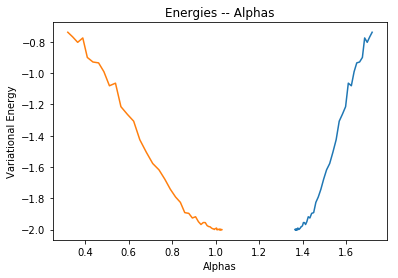

In [ ]:
num_particles = 4
num_steps = 1000
H = Hamiltonian(num_particles)
opt = Optimizer(H, num_steps)
energy, parameters = opt.get_ground_state()